In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2025-02-08 16:14:08.275489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 16:14:08.467424: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 16:14:08.474468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/libfabric/1.19.0/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.15.0/lib:/opt/ohpc/pub/libs/

### Select region and time

In [2]:
### SEUS region
min_lat, max_lat = 24, 36
min_lon, max_lon = 360-91, 360-77

t0,t1 = '1979-01-01', '1979-03-31'

### Load ERA5 daily temperature data

In [3]:
var='t2m'
tfile='/data/esplab/shared/reanalysis/era5/daily/'+var+'/'
fname=var+'.*.nc'
dt=xr.open_mfdataset(tfile+fname,combine='nested',concat_dim='time')
dt=dt.rename({'latitude':'lat','longitude':'lon'})
dt=dt.reindex(lat=list(reversed(dt['lat'])))
dt=dt.sel(time=slice(t0,t1),lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))
dt

/home/psinghai/miniconda3/envs/tf2-env/lib/python3.10/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:  (lat: 49, time: 90, lon: 57)
Coordinates:
  * lat      (lat) float32 24.0 24.25 24.5 24.75 25.0 ... 35.25 35.5 35.75 36.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-03-31
  * lon      (lon) float32 269.0 269.2 269.5 269.8 ... 282.2 282.5 282.8 283.0
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(90, 49, 57), meta=np.ndarray>
Attributes:
    comments:      Daily data created from: mean of hourly
    source:        Downloaded from Copernicus Data Store: https://cds.climate...
    CreationDate:  2023-07-28
    CreatedBy:     kpegion
    Source:        makeDaily.ipynb

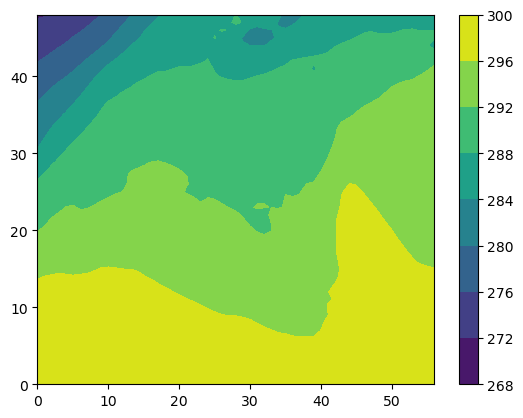

In [4]:
plt.contourf(dt[var][0,:,:])
plt.colorbar()

In [ ]:
#mean_temp = dt[var].mean(dim='time')
#std_temp = dt[var].mean(dim='time')
#dt_norm = (dt[var]-mean_temp)/std_temp
#dt_norm

## Reshape data to (time, lat*lon)

In [5]:
dt_feature = dt[var].stack(space=('lat','lon'))
dt_feature

<xarray.DataArray 't2m' (time: 90, space: 2793)>
dask.array<reshape, shape=(90, 2793), dtype=float32, chunksize=(90, 2793), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-03-31
  * space    (space) MultiIndex
  - lat      (space) float64 24.0 24.0 24.0 24.0 24.0 ... 36.0 36.0 36.0 36.0
  - lon      (space) float64 269.0 269.2 269.5 269.8 ... 282.2 282.5 282.8 283.0

In [6]:
### Normalize temperature data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dt_feature = scaler.fit_transform(dt_feature)
dt_feature

array([[1.        , 1.        , 1.        , ..., 0.86248016, 0.85940456,
        0.8540287 ],
       [0.50349426, 0.5181656 , 0.5358772 , ..., 0.97184753, 0.9813862 ,
        0.9857311 ],
       [0.        , 0.        , 0.        , ..., 0.28713036, 0.2857132 ,
        0.28899956],
       ...,
       [0.8364372 , 0.8440361 , 0.8524971 , ..., 0.86743927, 0.8555746 ,
        0.84324455],
       [0.8776932 , 0.8893242 , 0.90385437, ..., 0.99031353, 0.98983955,
        0.9927206 ],
       [0.9032173 , 0.9098511 , 0.9197426 , ..., 1.        , 0.998374  ,
        1.        ]], dtype=float32)

### Create sequences for time series forecasting

In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [11]:
seq_length = 10  # Use past 10 time steps to predict the next time step
X, Y = create_sequences(dt_feature, seq_length)
X.shape, Y.shape

((80, 10, 2793), (80, 2793))

### Split into training and testing sets

In [14]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
# Print dimensions to verify
print(X_train.sizes, X_test.sizes)
print(Y_train.sizes, Y_test.sizes)

In [15]:
# Reshape data for models
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape)
print(X_test.shape)

(64, 10, 2793, 1)
(16, 10, 2793, 1)


In [16]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X_train.shape[2], 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(X_train.shape[2])
])

# Compile and train the model
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test, Y_test))


2025-02-08 16:17:27.919337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/libfabric/1.19.0/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.15.0/lib:/opt/ohpc/pub/libs/hwloc/lib:/opt/ohpc/pub/mpi/openmpi4-gnu12/4.1.6/lib:/opt/ohpc/pub/compiler/gcc/12.4.0/lib64
2025-02-08 16:17:27.919390: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-08 16:17:27.919414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (esplab-0-2): /proc/driver/nvidia/version does not exist
2025-02-08 16:17:27.920977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 A

Epoch 1/10
4/4 [==============================] - 1s 175ms/step - loss: 13.9021 - val_loss: 0.6039
Epoch 2/10
4/4 [==============================] - 1s 135ms/step - loss: 0.3778 - val_loss: 0.6024
Epoch 3/10
4/4 [==============================] - 1s 132ms/step - loss: 0.3765 - val_loss: 0.6003
Epoch 4/10
4/4 [==============================] - 0s 129ms/step - loss: 0.3748 - val_loss: 0.5978
Epoch 5/10
4/4 [==============================] - 1s 130ms/step - loss: 0.3728 - val_loss: 0.5950
Epoch 6/10
4/4 [==============================] - 0s 131ms/step - loss: 0.3707 - val_loss: 0.5920
Epoch 7/10
4/4 [==============================] - 1s 135ms/step - loss: 0.3684 - val_loss: 0.5889
Epoch 8/10
4/4 [==============================] - 1s 130ms/step - loss: 0.3660 - val_loss: 0.5857
Epoch 9/10
4/4 [==============================] - 0s 128ms/step - loss: 0.3635 - val_loss: 0.5823
Epoch 10/10
4/4 [==============================] - 1s 134ms/step - loss: 0.3610 - val_loss: 0.5789


In [26]:
X1_train = np.squeeze(X_train, axis=-1)  # Removes the last dimension (channel dimension)
X1_test = np.squeeze(X_test, axis=-1)    # Same for X_test

In [ ]:
X1_train = X1_train.transpose('time','sequence','space')  # Transpose to (batch_size, sequence_length, features)
X1_test = X1_test.transpose('time','sequence','space')    # Same for X_test
X1_train.sizes, Y_train.sizes

In [20]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, X_train.shape[2], 1)),
    SimpleRNN(50, activation='relu'),
    Dense(X_train.shape[2])
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test, Y_test))

ValueError: Input 0 of layer "simple_rnn_4" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 10, 2793, 1)

In [ ]:
#X_train = X_train.transpose('sequence', 'time','space')  # Transpose to (batch_size, sequence_length, features)
#X_test = X_test.transpose('sequence','time', 'space')    # Same for X_test
#X_train

In [21]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),
    Dense(X_train.shape[2])
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test, Y_test))

Epoch 1/10
4/4 [==============================] - 2s 145ms/step - loss: 0.4028 - val_loss: 0.9450
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 0.3664 - val_loss: 0.5037
Epoch 3/10
4/4 [==============================] - 0s 40ms/step - loss: 0.2839 - val_loss: 0.3539
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 0.1905 - val_loss: 0.2139
Epoch 5/10
4/4 [==============================] - 0s 41ms/step - loss: 0.1343 - val_loss: 0.1341
Epoch 6/10
4/4 [==============================] - 0s 44ms/step - loss: 0.0889 - val_loss: 0.1016
Epoch 7/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0651 - val_loss: 0.0514
Epoch 8/10
4/4 [==============================] - 0s 43ms/step - loss: 0.0470 - val_loss: 0.0517
Epoch 9/10
4/4 [==============================] - 0s 39ms/step - loss: 0.0407 - val_loss: 0.0379
Epoch 10/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0356 - val_loss: 0.0361


In [22]:
# Predictions
y_pred_cnn = cnn_model.predict(X_test)
#y_pred_rnn = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)


1/1 [==============================] - 0s 265ms/step


In [24]:
# Inverse transform predictions
y_test_inv = scaler.inverse_transform(Y_test)
y_pred_cnn_inv = scaler.inverse_transform(y_pred_cnn)
#y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)


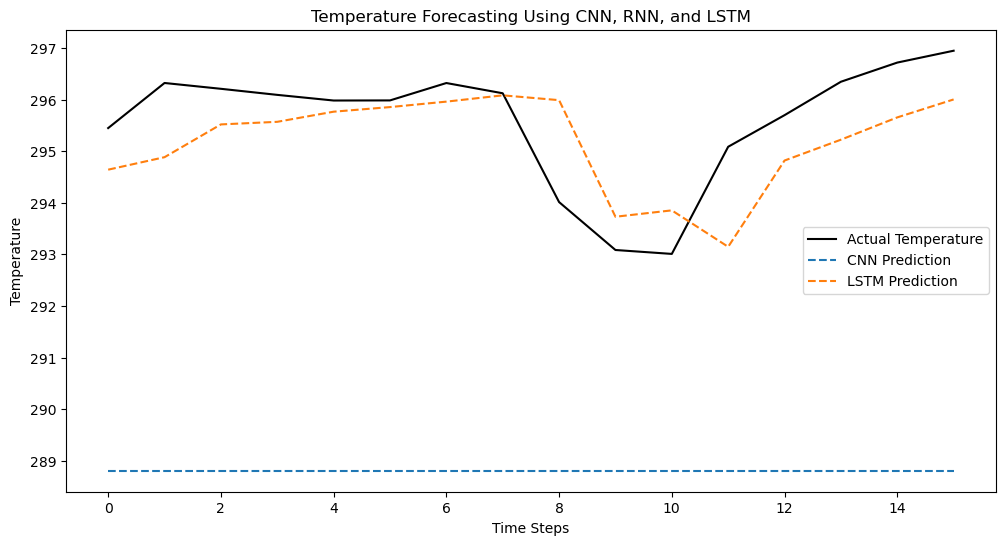

In [25]:
# Plot results for a single grid point (example: first location)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual Temperature', color='black')
plt.plot(y_pred_cnn_inv[:, 0], label='CNN Prediction', linestyle='dashed')
#plt.plot(y_pred_rnn_inv[:, 0], label='RNN Prediction', linestyle='dashed')
plt.plot(y_pred_lstm_inv[:, 0], label='LSTM Prediction', linestyle='dashed')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('Temperature Forecasting Using CNN and LSTM')
plt.show()